<font size=5>**Verificação da Concordância na Primeira Etapa (Treinamento 1)**</font>

O objetivo é quantificar o grau de entendimento entre os anotadores ao na primeira etapa de treinamento.

<font size=3>**Resultados Esperados**</font>

Nessa etapa todos os alunos receberam a mesma coleção de decisões. No segundo nível de anotação os alunos anotavam aquilo que ele mesmo anotou no decisão.

1. A concordância entre cada um dos alunos para a marcação de documentos (**apenas as marcações de primeiro nível**).
    - O resultado é uma matriz com a concordância entre anotadores de tamanho n x n (sendo n o total de anotadores).

2. Percentual médio de concordância entre anotadores por label (exemplo: qual o percentual médio de vezes em que um aluno concordou com o outro quando um marcou um tokem como doutrina?).

    - Esse percentual vai indicar qual label foi mais difícil de marcar que a outra
    - O resultado é uma matriz l x l (sendo l o total de labels)

3. Lista anotadores que tiveram uma concordância média de kappa superior a 0.75

Checklist:<br>
<input type="checkbox"> Verificar a concordância entre cada um dos alunos<br>
<input type="checkbox"> Verificar percentual de concordância entre anotadores por label<br>
<input type="checkbox"> Listar anotadores que tiveram uma concordância média superior a 0.75<br>


In [102]:
import os
import glob
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
import seaborn as sns
import spacy
from spacy import displacy
from sklearn.metrics import confusion_matrix

# Testes

Teste inicial para cálculo da concordância, sem uso dos dados limpos pós-processamento.

Mudanças que virão usando os dados processados:<br>
- Algumas facilidades com discordâncias pequenas (devido a coisas como "# Mover B_  com Token vazio para linha abaixo")
- Base de dados com todos os documentos juntos (um concatenado ao outro, não precisando se preocupar com arquivos separados)

In [2]:
# Encontra todos os csv's do treino dentro das pastas de 'mock'
extension = 'csv'
all_filenames = [i for i in glob.glob('mock/*/treino_1/Documentos/**.{}'.format(extension))]

In [3]:
all_filenames.sort()

In [4]:
all_filenames

['mock/161704902/treino_1/Documentos/562.ner.csv',
 'mock/161704902/treino_1/Documentos/563.ner.csv',
 'mock/161704902/treino_1/Documentos/564.ner.csv',
 'mock/161704902/treino_1/Documentos/565.ner.csv',
 'mock/171300011/treino_1/Documentos/542.ner.csv',
 'mock/171300011/treino_1/Documentos/543.ner.csv',
 'mock/171300011/treino_1/Documentos/544.ner.csv',
 'mock/171300011/treino_1/Documentos/545.ner.csv',
 'mock/171300018/treino_1/Documentos/458.ner.csv',
 'mock/171300018/treino_1/Documentos/459.ner.csv',
 'mock/171300018/treino_1/Documentos/460.ner.csv',
 'mock/171300018/treino_1/Documentos/461.ner.csv',
 'mock/171300023/treino_1/Documentos/410.ner.csv']

In [5]:
df1 = pd.read_csv(all_filenames[0], delimiter=';', na_values='NaN')
df2 = pd.read_csv(all_filenames[4], delimiter=';', na_values='NaN')

<font size=5>**Cohen's Kappa**</font>

Cohens Kappa:

$$ \kappa = \frac{p_o - p_e}{1 - p_e} $$

- $p_e$ é a probabilidade de concordarem por sorte
- $p_o$ é a percentagem relativa de concordância


**Exemplo:**
Olhando para uma matriz de confusão com 2 categorias.

\begin{matrix}
    &B(1)&B(2)\\
A(1)&a & b \\
A(2)&c & d
\end{matrix} 
<br>
<br>
<center>A percentagem relativa de concordância é</center>
$$ p_o = \frac{a+d}{a+b+c+d} $$
<br>
<br>
<center> A probabilidade de A e B concordarem por sorte ao categorizar como (1) é</center>
$$ p_{1A}p_{1B}  = \frac{a+b}{a+b+c+d}\frac{a+c}{a+b+c+d}$$
<br>
<br>
<center> A probabilidade de A e B concordarem por sorte ao categorizar como (2) é</center>
$$ p_{2A}p_{2B}  = \frac{c+d}{a+b+c+d}\frac{b+d}{a+b+c+d}$$
<br>
<br>
<center>Logo, a probabilidade de A e B concordarem por sorte num item qualquer fica:</center>
$$ p_e = p_{1A}p_{1B} + p_{2A}p_{2B}$$

## Kappa por Token

Vamos tomar como "itens classificados" cada Token do texto.

Vantagens: <br>
- Mais simples de calcular

Desvantagens:<br>
- Possível muita concordância entre 'O' pela simplicidade.
- Pequenos erros na anotação (um espaço extra ou a menos) afeta.

In [132]:
def tag_num(y):
    """
    Função para transformar vetor de tags complexas em vetor de labels numéricos.
    """
    
    # Lista de todas as tags possíveis
    tags = ['O', 'B_Precedente', 'I_Precedente', 'B_Ref. Legislativa',
       'I_Ref. Legislativa', 'B_Pessoa', 'I_Pessoa', 'B_Doutrinador',
       'I_Doutrinador']
    
    # Montando uma correspondência entre tags e posição na matrix de confusão
    tags_dict = {y:x for (x,y) in enumerate(tags)}
    
    # Vetor com labels numéricos no lugar da 
    y_new = np.vectorize(tags_dict.get)(y)
    
    return y_new

In [133]:
def conf_matrix(y1, y2):
    """
    Função para montar a matrix de confusão entre vetores de classificação y1 e y2
    """
    
    # Macete usado pelo sklearn: ao montar matrizes esparsas COO com scipy, 
    # índices repetidos da matriz são somados na montagem
    weight = np.ones(len(y1))
    confusion = scipy.sparse.coo_matrix((weight, (y1, y2)), shape=(9, 9))
    
    return np.array(confusion.toarray())

In [134]:
def cohen_kappa_token(confusion_matrix):
    """
    Função para cálculo do Cohen's Kappa a partir de uma matriz de confusão
    """
    
    # Calculando o Cohen's Kappa
    total = confusion_matrix.sum() # Total de Tokens avaliados
    po = np.trace(confusion_matrix)/total # Percentagem relativa de concordância
    
    # Vetor de probabilidades de 1 e de 2
    p1 = confusion_matrix.sum(axis=1)/total # Soma das classificações nas linhas
    p2 = confusion_matrix.sum(axis=0)/total # Soma das classificações nas colunas
    
    # Calculando a chance de 1 e 2 concordarem por sorte
    pe = np.dot(p1, p2)
    
    # Calculando Cohen's Kappa
    kappa = (po-pe)/(1.0-pe)
    
    return kappa

In [135]:
def percentual_by_label(confusion_matrix):
    """
    Função para cálculo do percentual de concordância por label a partir de uma matriz de confusão
    """
    
    # Calculo do percentual por label
    label_percentual = confusion_matrix/confusion_matrix.sum()
    
    return label_percentual

In [136]:
def percentual_total(confusion_matrix):
    """
    Função para cálculo do percentual de concordância total a partir de uma matriz de confusão
    """
    
    #Calculando a concordância percentual total
    total = confusion_matrix.sum() # Total de Tokens avaliados
    po = np.trace(confusion_matrix)/total # Percentagem relativa de concordância
    
    return np.trace(confusion_matrix)

In [137]:
def analise_dados(y1, y2):
    
    y1n = tag_num(y1)
    y2n = tag_num(y2)
    
    confusion_matrix = conf_matrix(y1n, y2n)
    
    kappa = cohen_kappa_token(confusion_matrix)
    label_percentuais = percentual_by_label(confusion_matrix)
    concord_percent = percentual_total(confusion_matrix)
    
    return kappa, concord_percent, label_percentuais

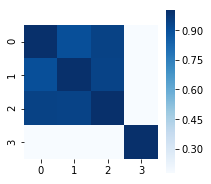

In [138]:
dic_pos = {0:0, 4:1, 8:2, 12:3}
kappa_matrix = np.zeros((4,4))
percent_matrix = np.zeros((4,4))
conf_matrices = []

for n in [0, 4, 8, 12]:
    for m in [0, 4, 8, 12]:

        df1_temp = pd.read_csv(all_filenames[n], delimiter=';', na_values='NaN')
        df2_temp = pd.read_csv(all_filenames[m], delimiter=';', na_values='NaN')
        
        Tags1 = df1_temp.loc[:, 'Tag'].values
        Tags2 = df2_temp.loc[:, 'Tag'].values
        
        k, percent, matriz_labels = analise_dados(Tags1, Tags2)
        
        kappa_matrix[dic_pos[n], dic_pos[m]] = k
        percent_matrix[dic_pos[n], dic_pos[m]] = percent
        conf_matrices.append(matriz_labels)
        
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(kappa_matrix, ax=ax, square=True, cmap='Blues')

## Kappa por bloco de anotação

Vamos tomar como "itens classificados" blocos completos de anotação.

Vantagens: <br>
- Foco no que nos interessa

Desvantagens:<br>
- Complicado de calcular (o que fazer com casos não exatamente iguais?)

Testando displacy

In [16]:
words = df1.iloc[60:100].Token.values
texto = ''.join(words)
sizes = np.cumsum([len(word) for word in words])

tags = df1.iloc[60:100].Tag.values

start = np.where(tags==tags[tags!='O'][0])[0][0]
start = sizes[start-1]
end = np.where(tags==tags[tags!='O'][1])[0][-1]
end = sizes[end]

rendering = [{"text":texto,
              "ents":[{"start":start, "end":end, "label":"P"}],
              "title":"aluno_1"}]
colors = {"P":"cyan"}
options = {"ents":None, "colors":colors}
html = displacy.render(rendering, style="ent", manual=True, options=options)
display(HTML(html))

In [17]:
words = df2.iloc[60:100].Token.values
texto = ''.join(words)
sizes = np.cumsum([len(word) for word in words])

tags = df2.iloc[60:100].Tag.values

start = np.where(tags==tags[tags!='O'][0])[0][0]
start = sizes[start-1]
end = np.where(tags==tags[tags!='O'][1])[0][-1]
end = sizes[end]

rendering = [{"text":texto,
              "ents":[{"start":start, "end":end, "label":"P"}],
              "title":"aluno_2"}]
colors = {"P": "cyan"}
options = {"ents":None, "colors":colors}
html = displacy.render(rendering, style="ent", manual=True, options=options)
display(HTML(html))

**Pegando discordâncias**

In [21]:
df1['tagged'] = np.zeros((df1.shape[0], 1), dtype=int)
df2['tagged'] = np.zeros((df1.shape[0], 1), dtype=int)

In [22]:
rows =df1.iterrows()
word = 0
for row in rows:
    if row[1][1][0] =="B":
        word += 1
        df1.loc[row[0], 'tagged'] = word
    elif row[1][1][0] =="I":
        df1.loc[row[0], 'tagged'] = word

In [23]:
rows =df2.iterrows()
word = 0
for row in rows:
    if row[1][1][0] =="B":
        word += 1
        df2.loc[row[0], 'tagged'] = word
    elif row[1][1][0] =="I":
        df2.loc[row[0], 'tagged'] = word

In [42]:
print("Aluno 1 teve {} blocos de anotações".format(df1.tagged.max()))
print("Aluno 2 teve {} blocos de anotações".format(df2.tagged.max()))

Aluno 1 teve 43 blocos de anotações
Aluno 2 teve 46 blocos de anotações


In [55]:
concord = []
discord = []
for n in range(1, df1.tagged.max()+1):
    d1 = df1.loc[df1.tagged==n, :].index.values
    
    tag1 = df1.loc[d1, 'Tag'].values
    tag2 = df2.loc[d1, 'Tag'].values
    
    is_equal = True
    for m in range(len(tag1)):
        if tag1[m] != tag2[m]:
            is_equal=False
            break
        
    if is_equal:
        concord.append(n)
    else:
        discord.append(n)

In [78]:
discord

[2, 13, 17, 31, 33, 36, 41]

In [97]:
d1 = df1.loc[df1.tagged==41, :].index.values

In [98]:
d1

array([4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057,
       4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068,
       4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077])

In [101]:
df1.loc[df1.tagged==41]

,Token,Tag,tagged
4047,acórdão,B_Precedente,41
4048,,I_Precedente,41
4049,da,I_Precedente,41
4050,,I_Precedente,41
4051,5ª,I_Precedente,41
4052,,I_Precedente,41
4053,Turma,I_Precedente,41
4054,,I_Precedente,41
4055,do,I_Precedente,41
4056,,I_Precedente,41


In [102]:
df2.loc[d1]

,Token,Tag,tagged
4047,acórdão,O,0
4048,,O,0
4049,da,O,0
4050,,O,0
4051,5ª,O,0
4052,,O,0
4053,Turma,O,0
4054,,O,0
4055,do,O,0
4056,,O,0


In [105]:
concord = []
discord = []
for n in range(1, df1.tagged.max()+1):
    d1 = df2.loc[df2.tagged==n, :].index.values
    
    tag1 = df1.loc[d1, 'Tag'].values
    tag2 = df2.loc[d1, 'Tag'].values
    
    is_equal = True
    for m in range(len(tag1)):
        if tag1[m] != tag2[m]:
            is_equal=False
            break
        
    if is_equal:
        concord.append(n)
    else:
        discord.append(n)

In [106]:
discord

[2, 13, 14, 17, 31, 32, 34, 37, 38, 41, 43]

In [128]:
N = 32

In [129]:
d1 = df2.loc[df2.tagged==N, :].index.values

In [130]:
d1

array([2700, 2701, 2702, 2703, 2704, 2705])

In [131]:
df2.loc[df2.tagged==N]

,Token,Tag,tagged
2700,Ministro,B_Pessoa,32
2701,,I_Pessoa,32
2702,Cezar,I_Pessoa,32
2703,,I_Pessoa,32
2704,Peluso,I_Pessoa,32
2705,",",I_Pessoa,32


In [132]:
df1.loc[d1]

,Token,Tag,tagged
2700,Ministro,I_Precedente,31
2701,,I_Precedente,31
2702,Cezar,I_Precedente,31
2703,,I_Precedente,31
2704,Peluso,I_Precedente,31
2705,",",I_Precedente,31


In [138]:
df1.iloc[2667:2705]

,Token,Tag,tagged
2667,O,B_Precedente,31
2668,,I_Precedente,31
2669,Plenário,I_Precedente,31
2670,,I_Precedente,31
2671,desta,I_Precedente,31
2672,,I_Precedente,31
2673,Corte,I_Precedente,31
2674,",",I_Precedente,31
2675,,I_Precedente,31
2676,em,I_Precedente,31


In [142]:
df2.iloc[2667:2705]

,Token,Tag,tagged
2667,O,O,0
2668,,O,0
2669,Plenário,O,0
2670,,O,0
2671,desta,O,0
2672,,O,0
2673,Corte,O,0
2674,",",O,0
2675,,O,0
2676,em,O,0


# Possíveis problemas

No caso em que um bloco de anotações contenha o outro, não é problemático avaliar. Os problemas surgem quando isso não é verdade.

1. Blocos diferentes devido a pequenas mudanças. No exemplo, o primeiro é pouco maior para a direita, o segundo é pouco maior para a esquerda.<br>
<br>

<div class="entities" style="line-height: 2.5"> TRABALHO DA 3ª REGIÃO, nos autos da <mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">reclamação trabalhista nº 00573-2010-050-03-00-3,  </mark>cuja decisão teria afrontado a autoridade do Supremo </div>

<div class="entities" style="line-height: 2.5">
TRABALHO DA 3ª REGIÃO, nos autos da<mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone"> reclamação trabalhista nº 00573-2010-050-03-00-3</mark>, cuja decisão teria afrontado a autoridade do Supremo </div>

2. Blocos diferentes devido a mudanças maiores em relação a caracteres, mas talvez não relevantes em relação a significado.

<div class="entities" style="line-height: 2.5"> TRABALHO DA 3ª REGIÃO, nos <mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">autos da reclamação trabalhista nº 00573-2010-050-03-00-3</mark>, cuja decisão teria afrontado a autoridade do Supremo </div>

<div class="entities" style="line-height: 2.5">
TRABALHO DA 3ª REGIÃO, nos autos da<mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone"> reclamação trabalhista nº 00573-2010-050-03-00-3, cuja</mark> decisão teria afrontado a autoridade do Supremo </div>

3. Blocos diferentes devido a mudanças maiores em relação a caracteres, mudança essa possivelmente não relevante.


<div class="entities" style="line-height: 2.5"><mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone"> art. 71, § 1º, da Lei federal nº 8.666, de 26 de junho de 1993, </mark></div>

<div class="entities" style="line-height: 2.5"><mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone"> art. 71, § 1º, da Lei federal nº 8.666,</mark> de 26 de junho de 1993, </div>



<div class="entities" style="line-height: 2.5"><mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">O Plenário desta Corte, em 24/11/2010, no julgamento da ADC nº 16/DF, Relator o Ministro Cezar Peluso</mark></div>
(Precendente)

<div class="entities" style="line-height: 2.5">O Plenário desta Corte, em 24/11/2010, no julgamento da <mark class="entity" style="background: cyan; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">ADC nº 16/DF,</mark> Relator o <mark class="entity" style="background: orange; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">Ministro Cezar Peluso</mark></div>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(Precedente)&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(Pessoa)